In [2]:
import keras
import numpy as np
import matplotlib.pyplot as plt
from keras import layers

In [4]:
model = keras.models.load_model("../Ch_08/convnet_from_scratch_with_augmentation.keras")
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 180, 180, 3)       0         
                                                                 
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_5 (Conv2D)           (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 89, 89, 32)       0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 87, 87, 64)        18496     
                                                           

In [5]:
img_path = keras.utils.get_file(
    fname='cat.jpg',
    origin='https://img-datasets.s3.amazonaws.com/cat.jpg')

80329/80329 [==============================] - 0s 5us/step


In [7]:
def get_img_array(img_path, target_size) :
    # 이미지 파일을 로드하고 원하는 크기로 변경
    img = keras.utils.load_img(img_path, target_size=target_size)
    # 이미지를 (180, 180, 3) 크기의 float32 넘파이 배열로 반환
    array = keras.utils.img_to_array(img)
    # 배열을 단일 이미지의 배치로 변환하기 위해 차원을 추가
    # 이제 배열의 크기는 (1, 180, 180, 3)
    array = np.expand_dims(array, axis=0)
    return array

In [8]:
img_tensor = get_img_array(img_path, target_size=(180, 180))

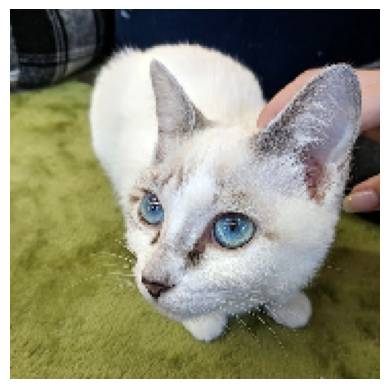

In [10]:
plt.axis('off')
plt.imshow(img_tensor[0].astype('uint8'))
plt.show()

In [11]:
# 특성 맵을 추출하기 위해 이미지 배치를 입력으로 받아 모든 합성곱과 풀링 층의 활성화를 출력

layer_outputs = []
layer_names = []

# isinstance(object, classinfo) 
for layer in model.layers :
    # 해당 층이 Conv2D 혹은 MaxPooling2D 층일 시
    if isinstance(layer, (layers.Conv2D, layers.MaxPooling2D)) :
        # 층의 출력을 하나의 리스트의 추가
        layer_outputs.append(layer.output)
        # 층의 이름을 저장
        layer_names.append(layer.name)

# 모델 입력이 주어졌을 때 층의 출력을 반환하는 모델
activation_model = keras.Model(inputs=model.input, outputs=layer_outputs)

In [12]:
activations = activation_model.predict(img_tensor)

1/1 [==============================] - 4s 4s/step


In [13]:
# 고양이 이미지에 대한 첫 번째 합성곱 층의 활성화 값
first_layer_activation = activations[0]
print(first_layer_activation.shape)

(1, 178, 178, 32)


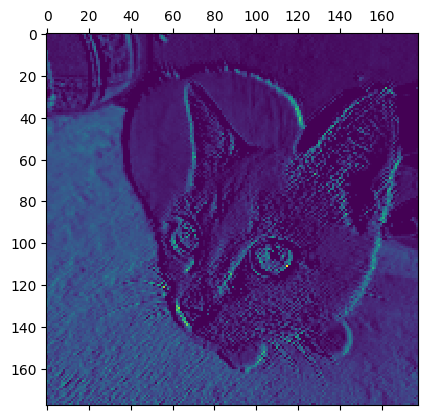

In [19]:
plt.matshow(first_layer_activation[0, :, :, 7], cmap='viridis')
plt.show()

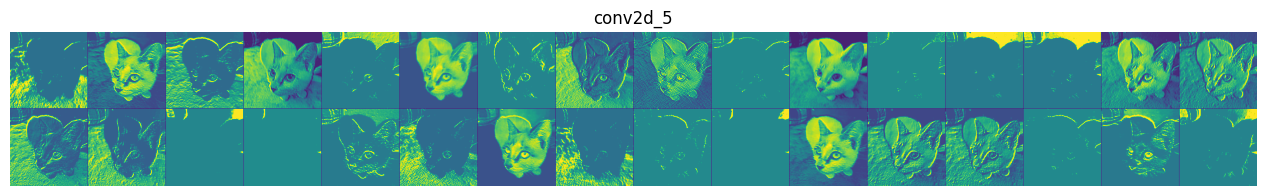

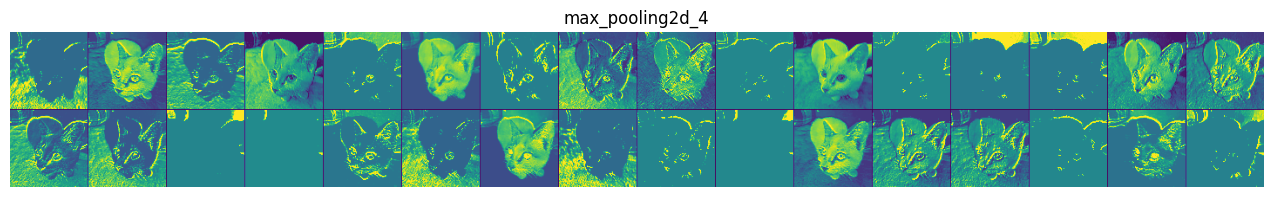

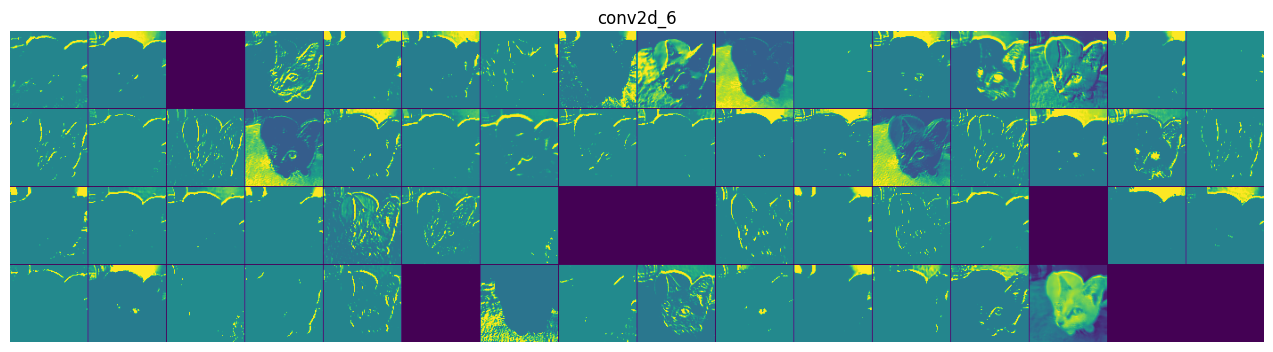

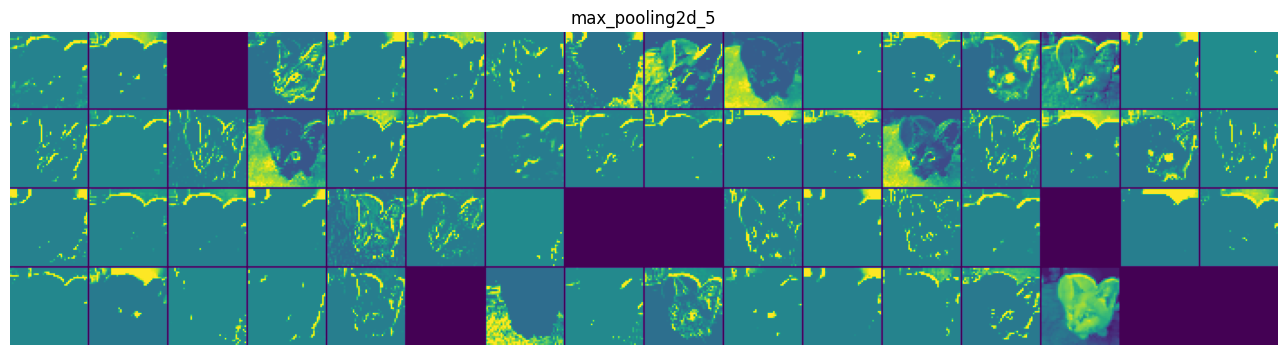

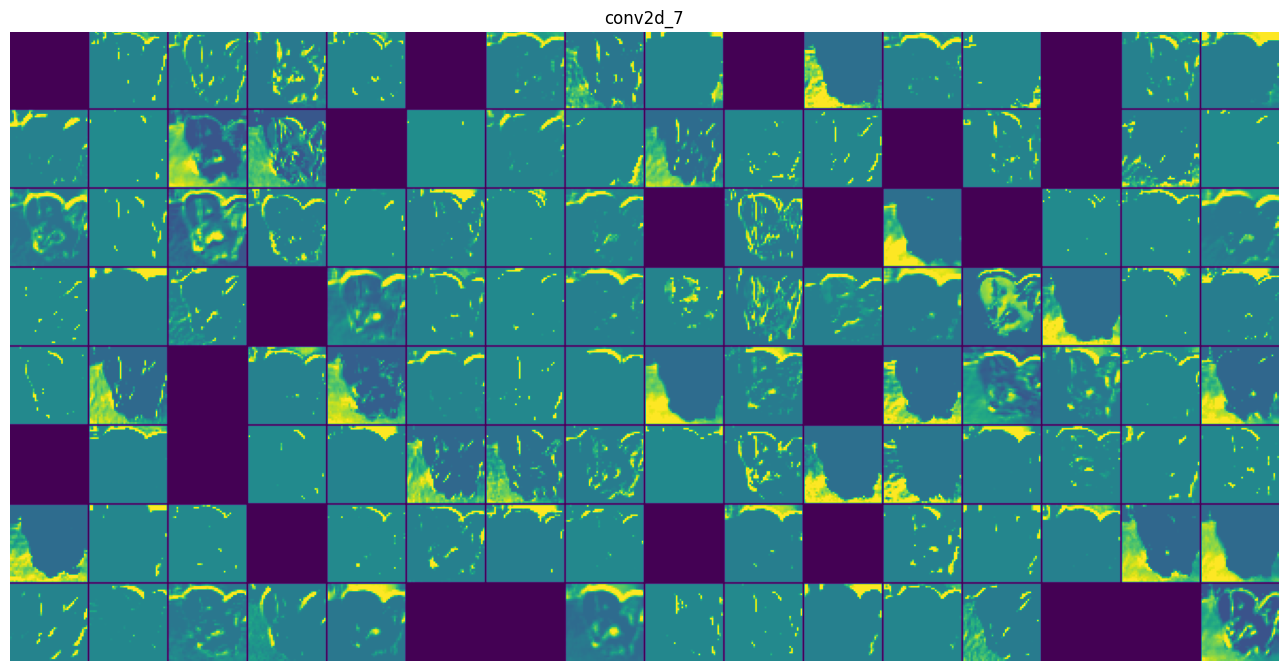

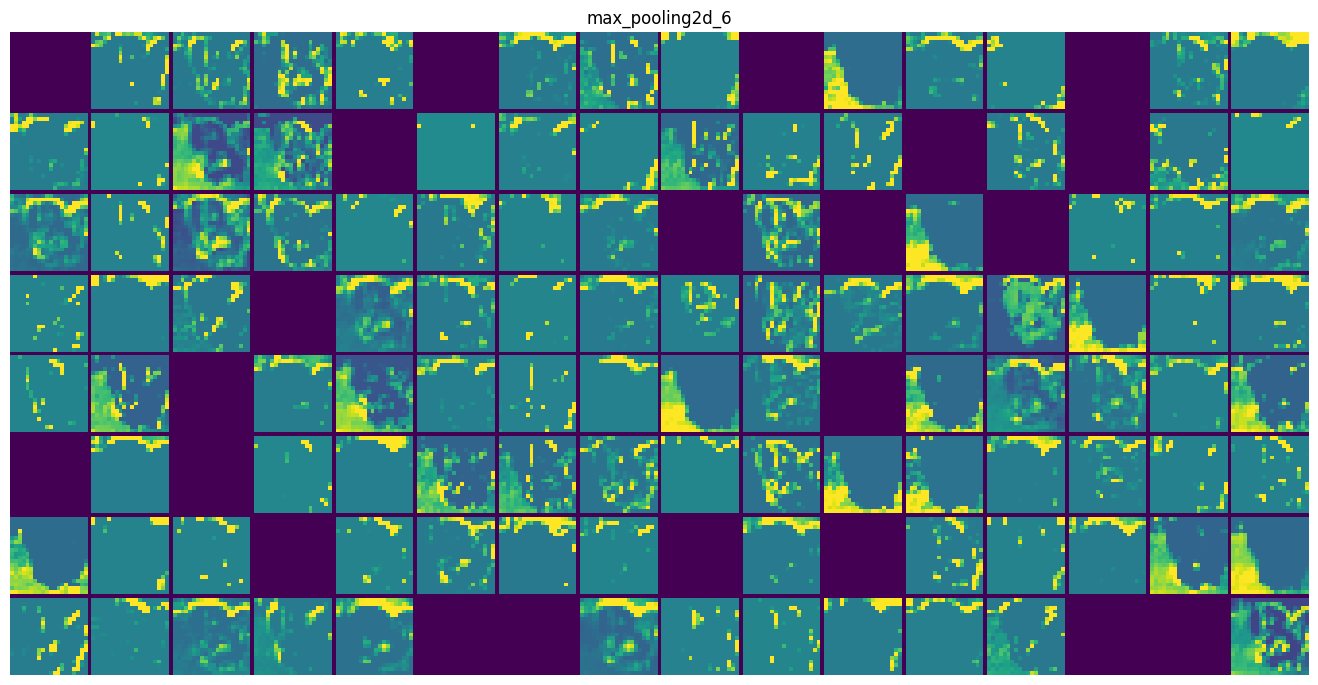

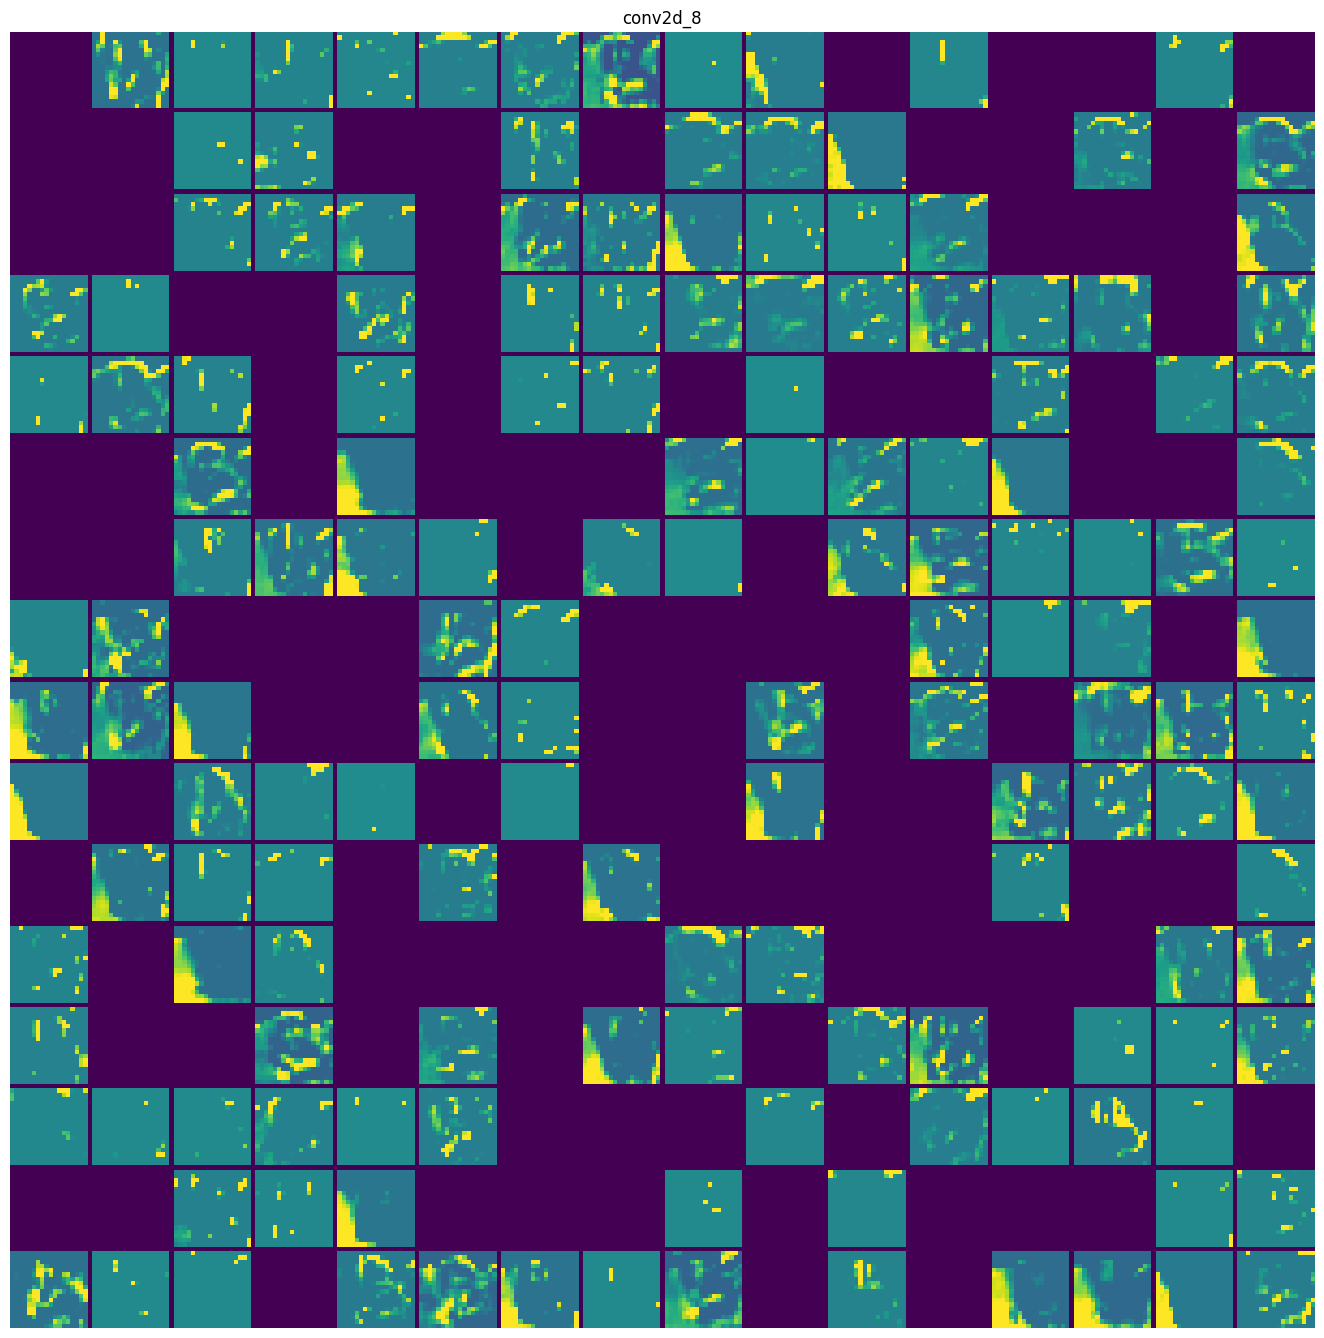

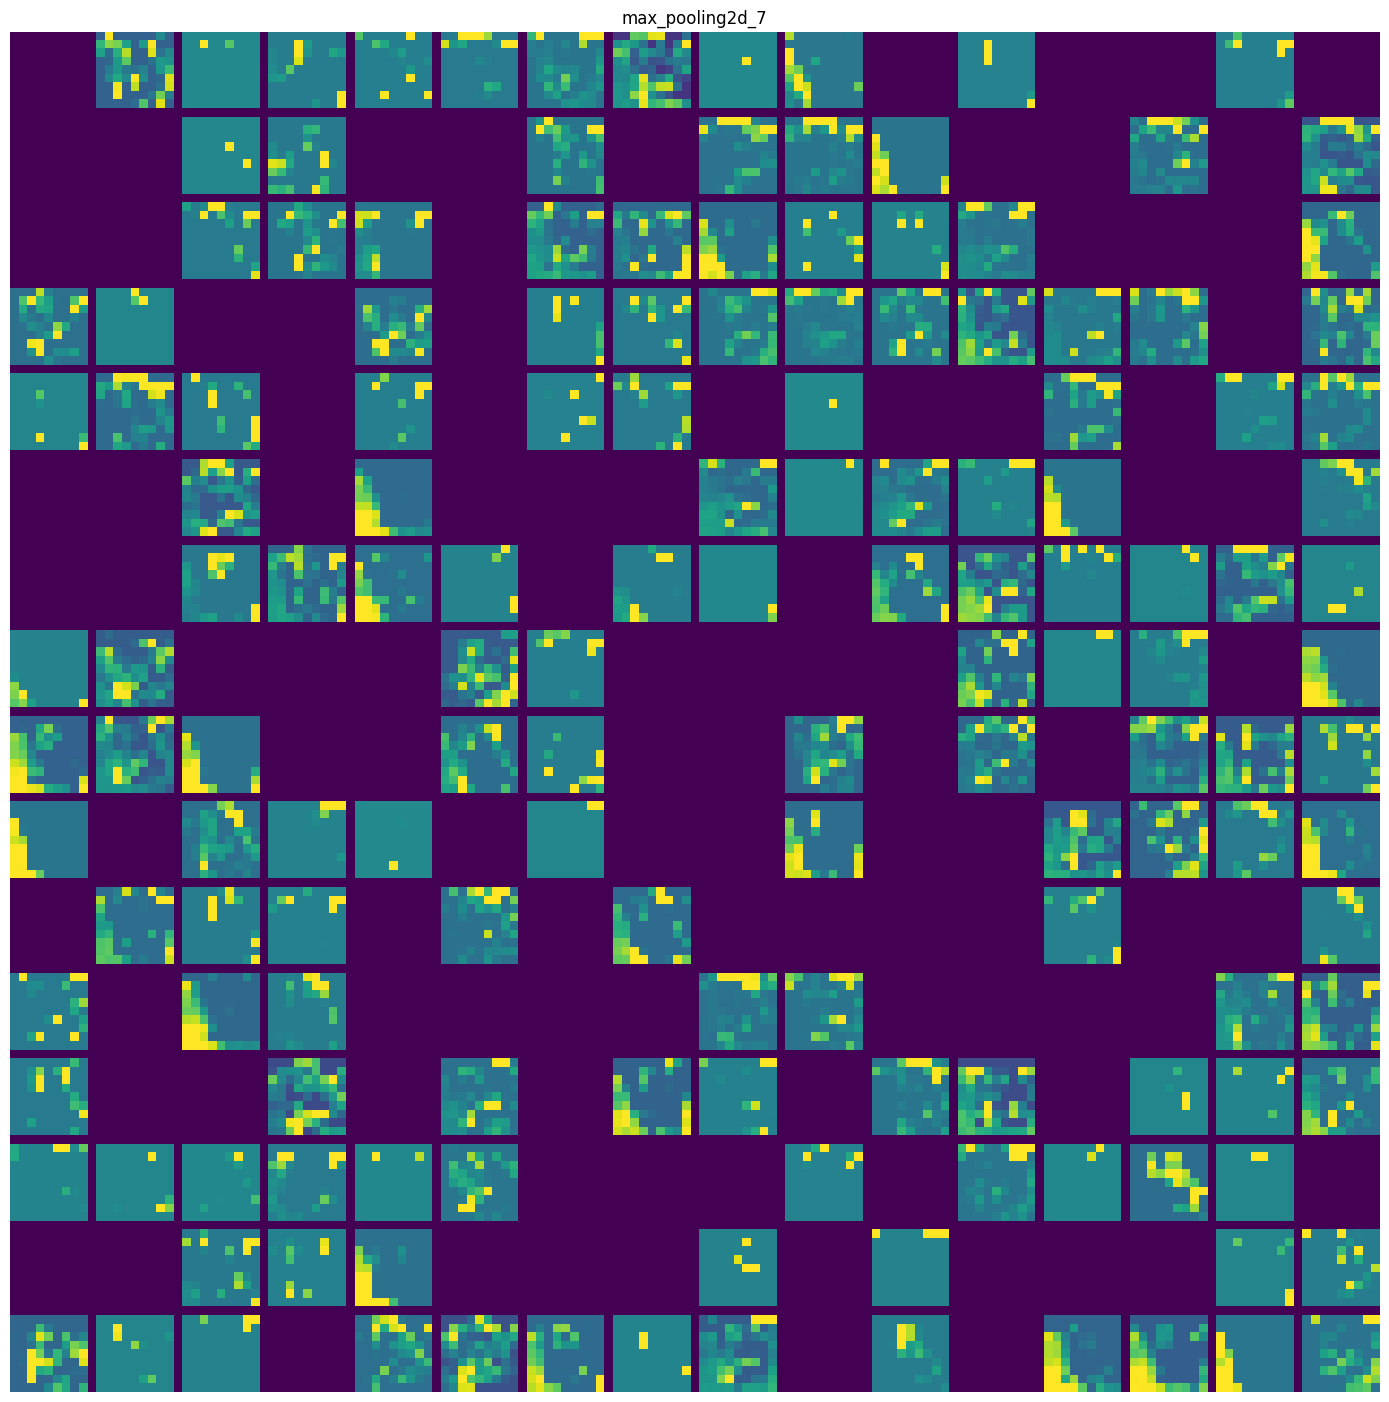

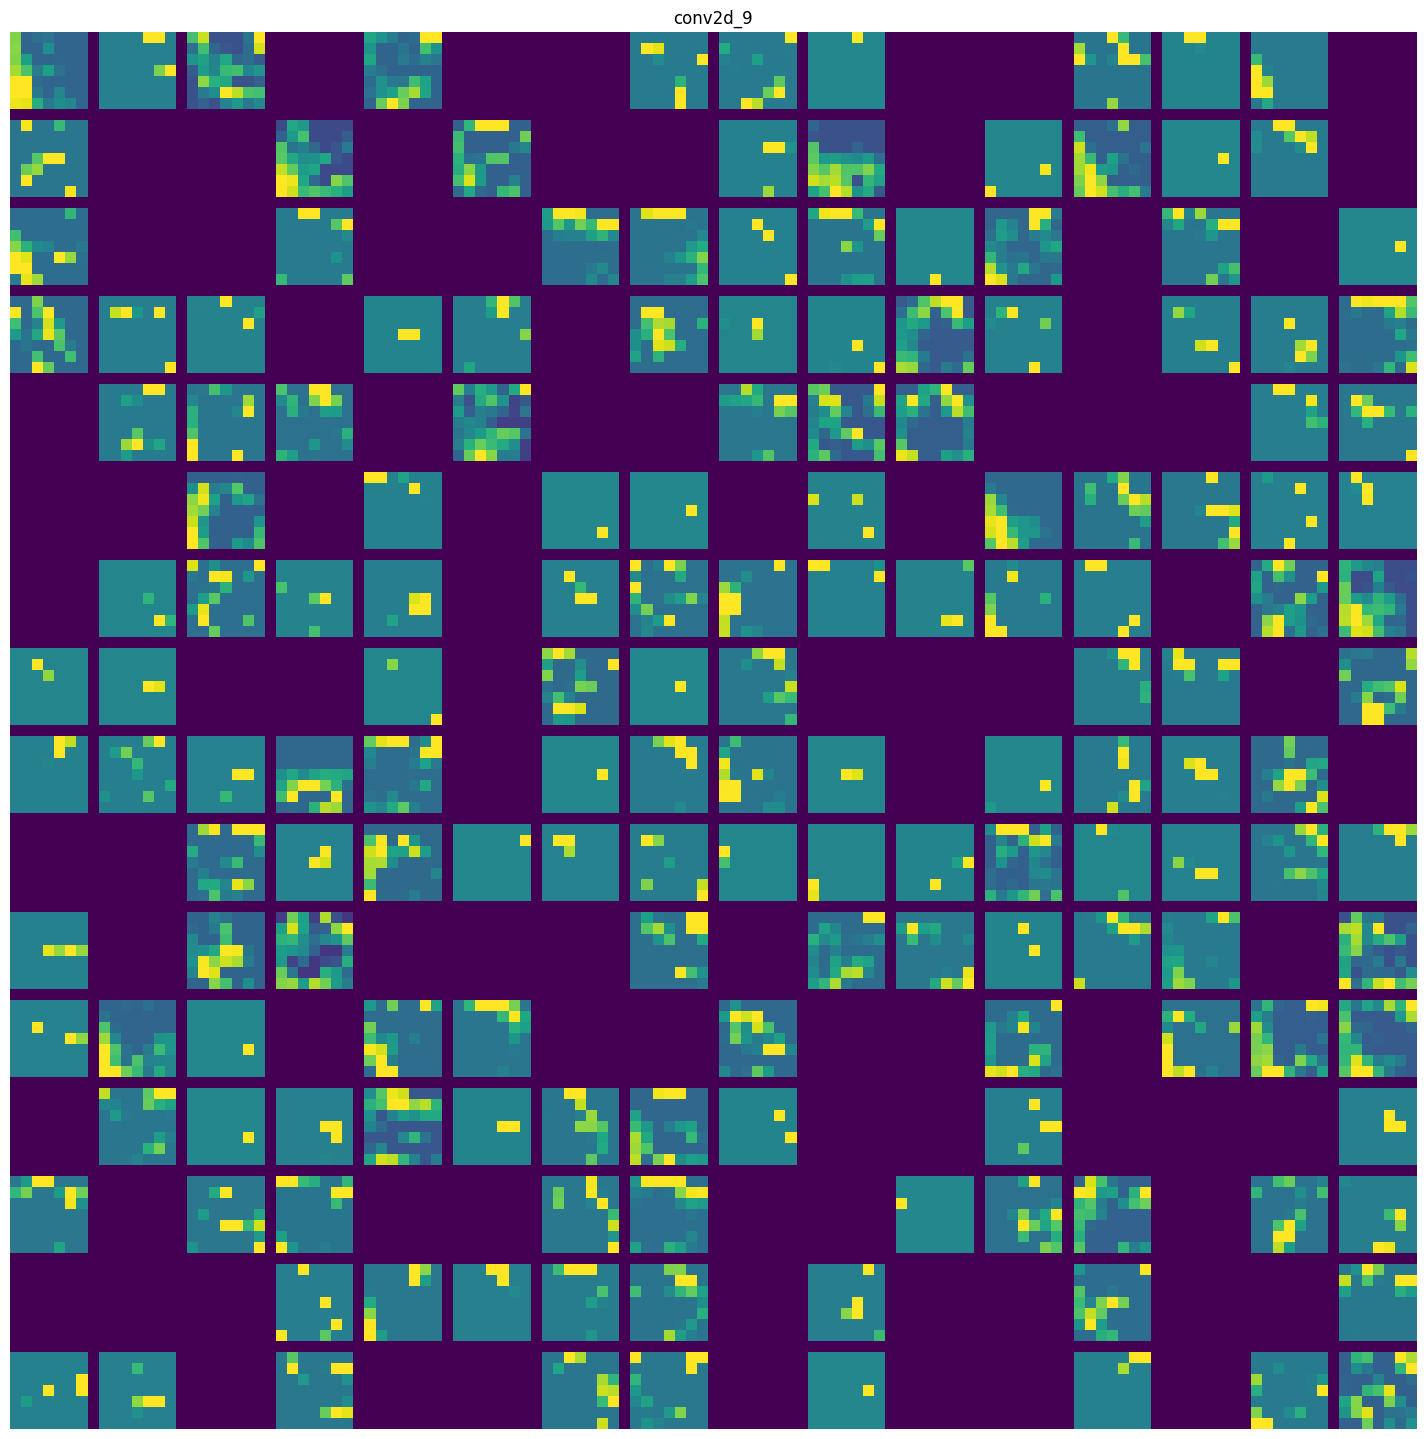

In [20]:
# 한 행마다 16개의 이미지를 출력
images_per_row = 16

# zip ( * iterables , strict = False ) 
# zip 객체는 n 길이의 튜플을 생성하며, 여기서 n은 zip()에 위치 인자로 전달된 이터러블의 수입니다. 
# 모든 튜플의 i번째 요소는 zip()에 대한 i번째 이터러블 인자에서 나옵니다. 
# 이 과정은 가장 짧은 인수가 소진될 때까지 계속됩니다.
for layer_name, layer_activation in zip(layer_names, activations) :
    # 총 활성화 크기는 (1, size, size, n_features)
    # (1, 178, 178, 32)
    n_features = layer_activation.shape[-1]
    size = layer_activation.shape[1]
    # 32 // 16 == 2
    n_cols = n_features // images_per_row
    # 활성화에 있는 모든 채널을 출력하기 위한 빈 그리드를 준비
    # (178 + 1) * 2 - 1 == 357
    # 16 * (178 + 1) - 1 == 2863
    # (357, 2863)
    display_grid = np.zeros(((size + 1) * n_cols - 1, images_per_row * (size + 1) - 1))
    
    # range(2)
    for col in range(n_cols) :
        # range(16)
        for row in range(images_per_row) :
            # col은 몇 번째 행인지 row는 몇 번째 열인지를 표시
            channel_index = col * images_per_row + row
            # 하나의 채널 이미지
            channel_image = layer_activation[0, :, :, channel_index].copy()
            
            # 모두 0인 채널은 그대로 둠
            if channel_image.sum() != 0 :
                # channel_image를 [0, 255] 범위로 정규화
                # -2 ~ 2?
                channel_image -= channel_image.mean()
                channel_image /= channel_image.std()
                # -128 ~ 128
                channel_image *= 64
                # 0 ~ 256
                channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')
            
            # 빈 그리드에 채널 행렬을 저장
            display_grid[
                col * (size + 1) : (col + 1) * size + col,
                row * (size + 1) : (row + 1) * size + row] = channel_image
    scale = 1. / size
    plt.figure(figsize=(scale * display_grid.shape[1], 
                        scale * display_grid.shape[0]))
    plt.title(layer_name)
    plt.grid(False)
    plt.axis('off')
    plt.imshow(display_grid, aspect='auto', cmap='viridis')